## Sensitivity Analysis for Global Seed

This jupyter notebook creates plots to study the impact of varying the global seed for base-case analysis

### 0. Analysis IDs to compare

In [1]:
# Define the analysis_ids that we want to compare
analysis_ids = (162, 163)

### 1. Package Installs

In [2]:
# python-dtenv to read the env variables
#!pip install python-dotenv

In [3]:
# Seaborn for plotting
#!pip install seaborn

In [4]:
# Plotly for plotting 
#!pip install plotly

In [5]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
from dotenv import load_dotenv
from pathlib import Path  # Python 3.6+ only
import os
import psycopg2
from plotly import graph_objects as go
from plotly.subplots import make_subplots
import plotly.express as px

### 2. Environment Variables

In [6]:
# Load the environment variables
env_path = Path('..') / '.env'
load_dotenv(dotenv_path=env_path)

True

In [7]:
# Print this to see if the env variables are read now
os.getenv("COMPOSE_PROJECT_NAME")

'evidss'

### 3. Database connection

In [8]:
# Generic function to test the connection to the database
def connect():
    """ Connect to the PostgreSQL database server """
    conn = None
    try:

        # connect to the PostgreSQL server
        print('Connecting to the PostgreSQL database...')
        conn = psycopg2.connect(    
            host=os.getenv("MAIN_HOST"),
            database=os.getenv("MAIN_DB"),
            user=os.getenv("DBREAD_USER"),
            password=os.getenv("DBREAD_PWD"), 
            port = os.getenv("MAIN_PORT")
        )
		
        # create a cursor
        cur = conn.cursor()
        
	# execute a statement
        print('PostgreSQL database version:')
        cur.execute('SELECT version()')

        # display the PostgreSQL database server version
        db_version = cur.fetchone()
        print(db_version)
       
	# close the communication with the PostgreSQL
        cur.close()
    except (Exception, psycopg2.DatabaseError) as error:
        print(error)
    finally:
        if conn is not None:
            conn.close()
            print('Database connection closed.')

In [9]:
# Make the test database connection
connect()

Connecting to the PostgreSQL database...
PostgreSQL database version:
('PostgreSQL 12.3 on x86_64-pc-linux-gnu, compiled by gcc (GCC) 4.8.5 20150623 (Red Hat 4.8.5-11), 64-bit',)
Database connection closed.


In [10]:
conn = psycopg2.connect(    
    host=os.getenv("MAIN_HOST"),
    database=os.getenv("MAIN_DB"),
    user=os.getenv("DBREAD_USER"),
    password=os.getenv("DBREAD_PWD"), 
    port = os.getenv("MAIN_PORT")
)

# create a cursor
cur = conn.cursor()

### 4. Database queries

In [11]:
cur.execute('select count(veh_id) from wa_bevs')
evs_in_wa = cur.fetchone()
evs_in_wa

(40667,)

In [12]:
sql_evs_in_sim = 'select count(veh_id), analysis_id from evtrip_scenarios where analysis_id IN %s group by analysis_id;'
# cur.mogrify(sql_evs_in_sim, (analysis_ids,))
evs_in_sim = pd.read_sql_query(sql=sql_evs_in_sim, con=conn, params=(analysis_ids,))
evs_in_sim

,count,analysis_id
0,1136,162
1,1125,163


In [13]:
sql_evs_fin = 'select count(veh_id), analysis_id from ev_finished where analysis_id IN %s group by analysis_id;'
# cur.mogrify(sql_evs_fin, (analysis_ids,))
evs_fin = pd.read_sql_query(sql=sql_evs_fin, con=conn, params=(analysis_ids,))
evs_fin

,count,analysis_id
0,1114,162
1,1089,163


In [14]:
sql_evs_str = 'select count(veh_id), analysis_id from ev_stranded where analysis_id IN %s group by analysis_id;'
# cur.mogrify(sql_evs_str, (analysis_ids,)) # Uncomment for debugging the query
evs_str = pd.read_sql_query(sql=sql_evs_str, con=conn, params=(analysis_ids,))
evs_str

,count,analysis_id
0,22,162
1,36,163


In [15]:
sql_evmt = 'select sum(distance_travelled), analysis_id from ev_finished where analysis_id IN %s group by analysis_id;'
# cur.mogrify(sql_evmt, (analysis_ids,))
evmt = pd.read_sql_query(sql=sql_evmt, con=conn, params=(analysis_ids,))
evmt

,sum,analysis_id
0,124748.0,162
1,119944.0,163


In [16]:
sql_cs = 'select count(cs_id), analysis_id from evse_charging_session where analysis_id IN %s group by analysis_id;'
# cur.mogrify(sql_cs, (analysis_ids,))
cs = pd.read_sql_query(sql=sql_cs, con=conn, params=(analysis_ids,))
cs

,count,analysis_id
0,734,162
1,777,163


In [17]:
sql_ws = 'select count(wait_id), analysis_id from evse_evs_waiting where analysis_id IN %s group by analysis_id;'
# cur.mogrify(sql_ws, (analysis_ids,))
ws = pd.read_sql_query(sql=sql_ws, con=conn, params=(analysis_ids,))
ws

,count,analysis_id
0,425,162
1,434,163


In [18]:
sql_evse_util = """SELECT epd.analysis_id,
       epd.simulation_ts::timestamp as datetime,
       sum(epd.power_val)           as total_power,
       ap.param_value               as global_seed
FROM evse_power_draw epd
         join (select param_value, analysis_id from analysis_params where param_id = 1) as ap
              on epd.analysis_id = ap.analysis_id
WHERE epd.analysis_id IN %s
GROUP BY epd.simulation_ts, epd.analysis_id, ap.param_value
ORDER BY global_seed, epd.simulation_ts::timestamp;"""
# cur.mogrify(sql_evse_util, (analysis_ids,))
evse_util = pd.read_sql_query(sql=sql_evse_util, con=conn, params=(analysis_ids,))
evse_util

,analysis_id,datetime,total_power,global_seed
0,163,2019-07-01 12:16:36,0,0
1,163,2019-07-01 12:17:36,0,0
2,163,2019-07-01 12:18:36,0,0
3,163,2019-07-01 12:19:36,0,0
4,163,2019-07-01 12:20:36,0,0
...,...,...,...,...
2312,162,2019-07-01 23:21:31,0,123
2313,162,2019-07-01 23:22:31,0,123
2314,162,2019-07-01 23:23:31,0,123
2315,162,2019-07-01 23:24:31,0,123


In [19]:
sql_count_stats = """select count(ets.veh_id) as sim_count,
       ets.analysis_id,
       ap.param_value,
       ef.fin_count,
       ef.evmt,
       es.str_count,
       ecs.cs_count,
       ew.wait_count
from evtrip_scenarios ets
         join (select param_value, analysis_id from analysis_params where param_id = 1) as ap
              on ets.analysis_id = ap.analysis_id
         join (select count(veh_id) as fin_count, sum(distance_travelled) as evmt, analysis_id
               from ev_finished
               group by analysis_id) as ef
              on ets.analysis_id = ef.analysis_id
         join (select count(veh_id) as str_count, analysis_id from ev_stranded group by analysis_id) as es
              on ets.analysis_id = es.analysis_id
         join (select count(cs_id) as cs_count, analysis_id from evse_charging_session group by analysis_id) as ecs
              on ets.analysis_id = ecs.analysis_id
join (select count(wait_id) as wait_count, analysis_id from evse_evs_waiting group by analysis_id) as ew
              on ets.analysis_id = ew.analysis_id
where ets.analysis_id IN %s
group by ets.analysis_id, ap.param_value, ef.fin_count, es.str_count, ef.evmt, ecs.cs_count, ew.wait_count
;"""
count_stats = pd.read_sql_query(sql=sql_count_stats, con=conn, params=(analysis_ids,))
count_stats

,sim_count,analysis_id,param_value,fin_count,evmt,str_count,cs_count,wait_count
0,1136,162,123,1114,124748.0,22,734,425
1,1125,163,0,1089,119944.0,36,777,434


In [20]:
count_stats.dtypes
count_stats = count_stats.sort_values(by=['param_value'])
count_stats

,sim_count,analysis_id,param_value,fin_count,evmt,str_count,cs_count,wait_count
1,1125,163,0,1089,119944.0,36,777,434
0,1136,162,123,1114,124748.0,22,734,425


In [42]:
sql_comp_stats = """select lai.action_tstamp_tx                                               as start_time,
       lau.aid,
       lau.action_tstamp_tx                                               as end_time_tripgen,
       las.action_tstamp_tx,
       '# EV: ' || es.ev_count as ev_count,
       ap.param_value,
       ((DATE_PART('day', lau.action_tstamp_tx - lai.action_tstamp_tx) * 24 +
         DATE_PART('hour', lau.action_tstamp_tx - lai.action_tstamp_tx)) * 60 +
        DATE_PART('minute', lau.action_tstamp_tx - lai.action_tstamp_tx)) as time_taken_tripgen,
       ((DATE_PART('day', las.action_tstamp_tx - lau.action_tstamp_tx) * 24 +
         DATE_PART('hour', las.action_tstamp_tx - lau.action_tstamp_tx)) * 60 +
        DATE_PART('minute', las.action_tstamp_tx - lau.action_tstamp_tx)) as time_taken_eviabm
from audit.logged_actions lai
         join (select action_tstamp_tx, action, row_data -> 'analysis_id' as aid
               from audit.logged_actions
               where action = 'U'
                 and changed_fields -> 'status' LIKE 'trips_generated') as lau
              on lau.aid = lai.row_data -> 'analysis_id'
         join (select action_tstamp_tx, action, row_data -> 'analysis_id' as aid
               from audit.logged_actions
               where action = 'U'
                 and changed_fields -> 'status' LIKE 'solved') as las
              on las.aid = lai.row_data -> 'analysis_id'
         join (select count(veh_id) as ev_count, analysis_id from public.evtrip_scenarios group by analysis_id) as es
              on es.analysis_id = (lai.row_data -> 'analysis_id')::int
         join (select param_value, analysis_id from analysis_params where param_id = 1) as ap
              on (lai.row_data -> 'analysis_id')::int = ap.analysis_id
where lai.action = 'I'
  and lai.row_data -> 'analysis_id' ~* %s
ORDER BY ap.param_value
;"""
data = '|'.join(map(str,analysis_ids))
comp_stats = pd.read_sql_query(sql=sql_comp_stats, con=conn, params=(data,))
comp_stats

,start_time,aid,end_time_tripgen,action_tstamp_tx,ev_count,param_value,time_taken_tripgen,time_taken_eviabm
0,2020-11-08 21:36:23.085453+00:00,163,2020-11-08 21:44:21.773965+00:00,2020-11-09 04:33:55.297260+00:00,# EV: 1125,0,7.0,409.0
1,2020-11-08 21:36:09.115723+00:00,162,2020-11-08 21:44:06.267115+00:00,2020-11-09 04:30:54.546589+00:00,# EV: 1136,123,7.0,406.0


### 5. Plotting

#### 5.1 Vehicle Counts

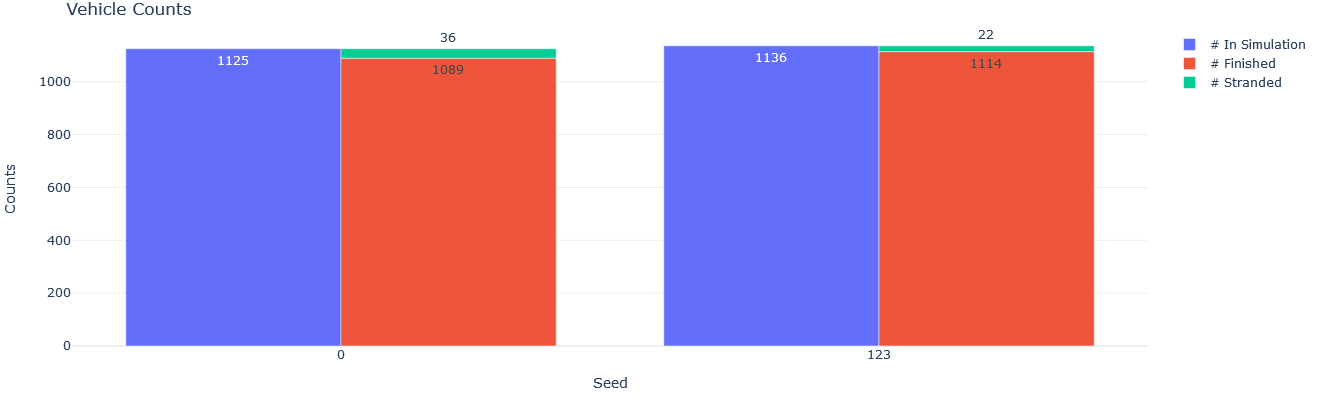

In [43]:
fig = go.Figure(
    data=[
        go.Bar(
            name="# In Simulation",
            x=count_stats['param_value'],
            y=count_stats['sim_count'],
            offsetgroup=0,
            text=count_stats['sim_count'],
            textposition='auto',
        ),
        go.Bar(
            name="# Finished",
            x=count_stats['param_value'],
            y=count_stats['fin_count'],
            offsetgroup=1,
            text=count_stats['fin_count'],
            textposition='auto',
        ),
        go.Bar(
            name="# Stranded",
            x=count_stats['param_value'],
            y=count_stats['str_count'],
            offsetgroup=1,
            base=count_stats['fin_count'],
            text=count_stats['str_count'],
            textposition='auto',
        )
    ],
    layout=go.Layout(
        title="Vehicle Counts",
        yaxis_title="Counts", 
        xaxis_title="Seed", width=600, height=400
        
    )
)
fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white')
fig.show()

#### 5.2 eVMT

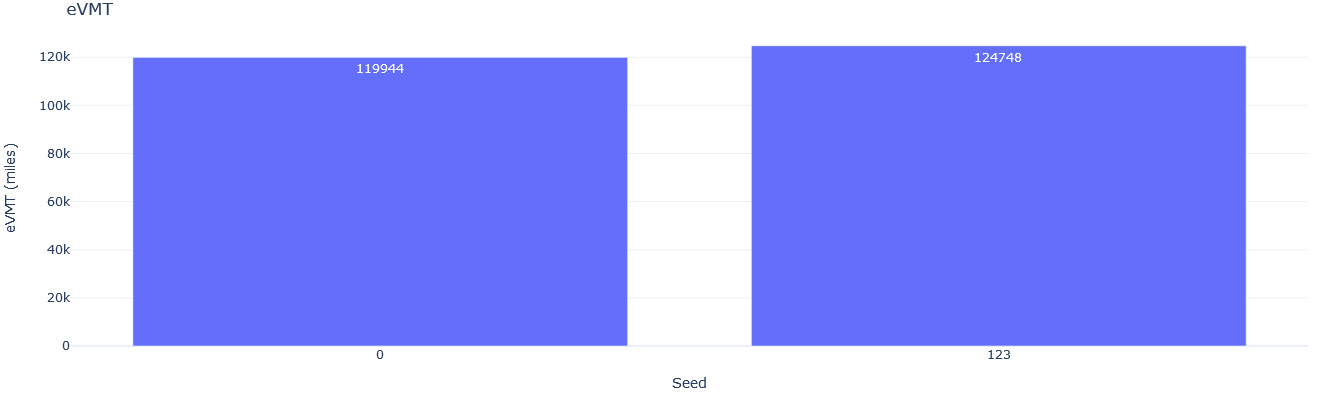

In [44]:
fig = go.Figure(
    data=[
        go.Bar(
            name="eVMT",
            x=count_stats['param_value'],
            y=count_stats['evmt'],
            offsetgroup=1,
            text=count_stats['evmt'],
            textposition='auto',
        )
    ],
    layout=go.Layout(
        title="eVMT",
        yaxis_title="eVMT (miles)", 
        xaxis_title="Seed", uniformtext_minsize=8, uniformtext_mode='hide', width=400, height=400
        
    )
)
fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white')
fig.show()

#### 5.3 Charging and Waiting Sessions

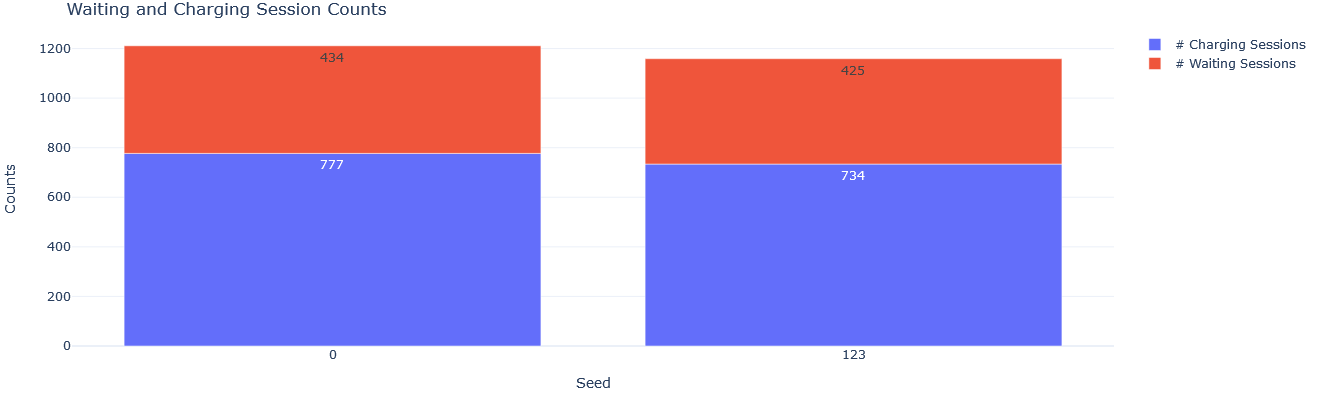

In [45]:
fig = go.Figure(
    data=[
        go.Bar(
            name="# Charging Sessions",
            x=count_stats['param_value'],
            y=count_stats['cs_count'],
            offsetgroup=1,
            text=count_stats['cs_count'],
            textposition='auto',
        ),
        go.Bar(
            name="# Waiting Sessions",
            x=count_stats['param_value'],
            y=count_stats['wait_count'],
            offsetgroup=1,
            base=count_stats['cs_count'],
            text=count_stats['wait_count'],
            textposition='auto',
        )
    ],
    layout=go.Layout(
        title="Waiting and Charging Session Counts",
        yaxis_title="Counts", 
        xaxis_title="Seed", width=600, height=400
        
    )
)
fig.update_xaxes(type='category')
fig.update_layout(margin=dict(l=20, r=20, t=30, b=20), uniformtext_minsize=8, uniformtext_mode='hide', template='plotly_white')
fig.show()

#### 5.4 EVSE Utilization

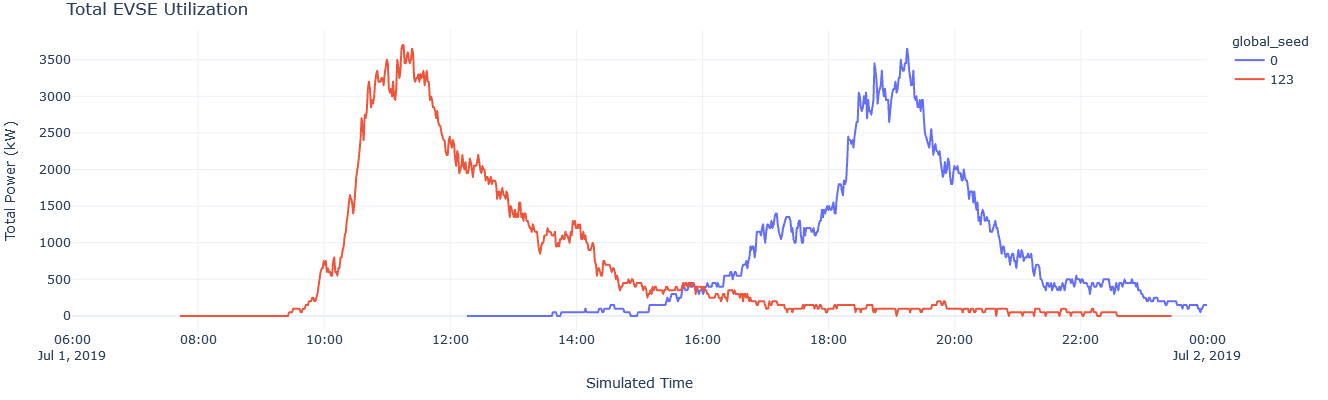

In [46]:
fig = px.line(evse_util, x="datetime", y="total_power", color='global_seed', labels='Global Seed', range_x=['2019-07-01 06:00','2019-07-02'])
fig.update_layout(title="Total EVSE Utilization",
                  yaxis_title="Total Power (kW)", 
                  xaxis_title="Simulated Time", 
                  uniformtext_minsize=8, 
                  uniformtext_mode='hide', 
                  width=1000, 
                  height=400, 
                  margin=dict(l=20, r=20, t=30, b=20), template='plotly_white')
fig.show()

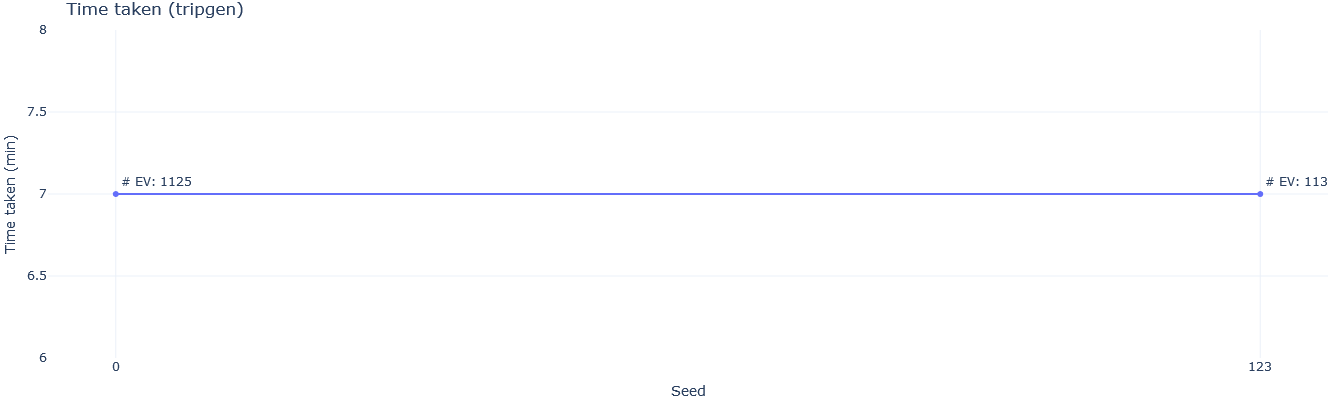

In [55]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=comp_stats['param_value'], y=comp_stats['time_taken_tripgen'],
                         mode='lines+markers+text',
                         name='lines+markers', 
                         text=comp_stats['ev_count'],
                         textposition="top right"))
fig.update_xaxes(type='category')
fig.update_layout(title="Time taken (tripgen)",
                  yaxis_title="Time taken (min)", 
                  xaxis_title="Seed", 
                  uniformtext_minsize=8, 
                  uniformtext_mode='hide', 
                  width=400, 
                  height=400, 
                  margin=dict(l=20, r=0, t=30, b=20),
                 template='plotly_white')
fig.show()

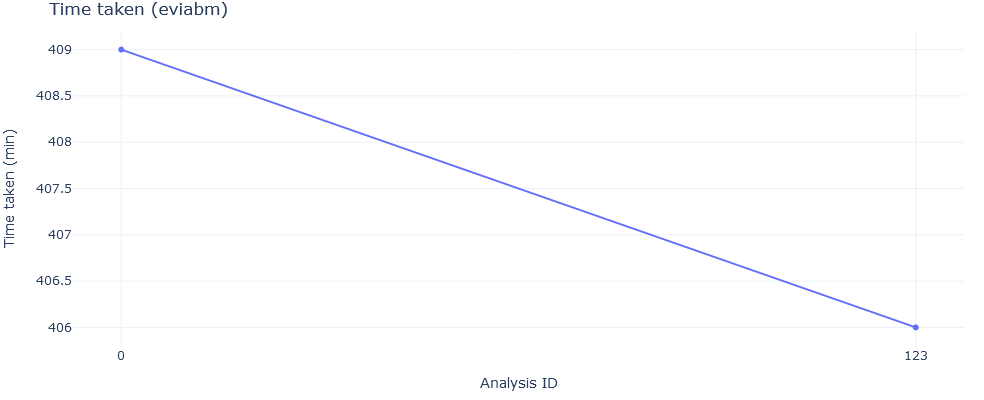

In [48]:
fig = go.Figure()
fig.add_trace(go.Scatter(x=comp_stats['param_value'], y=comp_stats['time_taken_eviabm'],
                    mode='lines+markers+text',
                    name='lines+markers'))
fig.update_xaxes(type='category')
fig.update_layout(title="Time taken (eviabm)",
                  yaxis_title="Time taken (min)", 
                  xaxis_title="Analysis ID", 
                  uniformtext_minsize=8, 
                  uniformtext_mode='hide', 
                  width=400, 
                  height=400, 
                  margin=dict(l=20, r=20, t=30, b=20),
                  template='plotly_white')
fig.show()

____________
____________

Things to do the first time if the plotly plots not showing. Restart jupyter lab after. 

In [1]:
#!jupyter labextension list

JupyterLab v2.2.6
Known labextensions:
   app dir: /root/anaconda3/share/jupyter/lab
        @jupyter-widgets/jupyterlab-manager v2.0.0  enabled  OK
        jupyterlab-plotly v4.12.0  enabled  OK
        plotlywidget v4.12.0  enabled  OK


In [26]:
#!jupyter labextension uninstall jupyterlab-plotly

In [27]:
#!jupyter labextension uninstall plotlywidget

In [28]:
#!export NODE_OPTIONS=--max-old-space-size=4096

In [29]:
#!pip show plotly

In [30]:
#!pip install jupyterlab "ipywidgets>=7.5"

In [31]:
#!jupyter labextension install jupyterlab-plotly@4.12.0

In [32]:
#!jupyter labextension install @jupyter-widgets/jupyterlab-manager plotlywidget@4.12.0

In [3]:
#!pip install "nbconvert<6"